# Основные библиотеки, константы и функции

In [1]:
import torch
import cv2
from PIL import Image
import os
import supervision as sv
import json
import matplotlib.pyplot as plt

In [37]:
VIDEO_DIR = "/home/jovyan/test_videos"
FRAMES_DIR = "/home/jovyan/test_frames"
ANNOTATION_DIR = "/home/jovyan/annotation"
OUTPUT_DIR = "/home/jovyan/results"

### Загрузка разметки

In [38]:
def load_ann(video_name):
    boxes = []
    labels = []
    annotation = {}
    with open(f'{ANNOTATION_DIR}/{video_name}.json', 'r') as f:
        ann_data = json.load(f)
    for ann in ann_data['annotations']:
        image_id = ann['image_id']
        if image_id not in annotation:
            annotation[image_id] = []
        annotation[image_id].append(ann.get("bbox"))
    return annotation

### Функции для bbox

In [39]:
def cxcywh_to_xywh(bbox, image_size):
    cx, cy, w, h = bbox
    return [(cx - 0.5 * w) * image_size[0], (cy - 0.5 * h) * image_size[1], 
            w * image_size[0], h * image_size[1]]

In [40]:
def xyxy_to_xywh(bbox):
    x1, y1, x2, y2 = bbox
    return [x1, y1, x2 - x1, y2 - y1]

### Функции подсчёта объёма ошибок

In [41]:
def calculate_iou(boxA, boxB):
    xA1, yA1, wA, hA = boxA
    xB1, yB1, wB, hB = boxB
    xA2, yA2 = xA1 + wA, yA1 + hA
    xB2, yB2 = xB1 + wB, yB1 + hB
    x1 = max(xA1, xB1)
    y1 = max(yA1, yB1)
    x2 = min(xA2, xB2)
    y2 = min(yA2, yB2)
    if x2 < x1 or y2 < y1:
        return 0.0
    intersection = (x2 - x1) * (y2 - y1)
    areaA = wA * hA
    areaB = wB * hB
    union = areaA + areaB - intersection
    return intersection / union

In [17]:
def errors_on_frame(predicted_boxes, annotated_boxes, iou_threshold):
    matched_ann = set()
    tp = 0
    fp = 0
    for prediction in predicted_boxes:
        match_found = False
        i = 0
        for annotation in annotated_boxes:
            if i in matched_ann:
                continue
            iou = calculate_iou(prediction, annotation)
            #print(prediction, annotation)
            if iou >= iou_threshold:
                match_found = True
                matched_ann.add(i)
                break
            i+=1
        if match_found:
            tp += 1
        else:
            fp += 1
    fn = len(annotated_boxes) - len(matched_ann)
    return tp, fp, fn


# Grounding DINO

[Ссылка на репозиторий](https://github.com/IDEA-Research/GroundingDINO)

### Загрузка модели

In [6]:
import sys
sys.path.append("/home/jovyan/Grounded-SAM-2")

In [ ]:
from groundingdino.util.inference import load_model, load_image, predict, annotate

dino_model = load_model(
    "/home/jovyan/models/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py",
    "/home/jovyan/models/GroundingDINO/weights/groundingdino_swint_ogc.pth"
)
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

### Запуск Grounding Dino

In [43]:
def dino_process_images_with_metrics(image_dir, prompt, save_imgs, image_size, iou_threshold):
    i = 1
    os.makedirs(f"{OUTPUT_DIR}/{image_dir}", exist_ok=True)
    total_tp = 0
    total_fp = 0
    total_fn = 0
    for frame in sorted(os.listdir(f"{FRAMES_DIR}/{image_dir}")):
        if frame[-4:] != '.jpg':
            continue
        image_source, image = load_image(f"{FRAMES_DIR}/{image_dir}/{frame}")
        boxes, logits, phrases = predict(
            model=dino_model,
            image=image,
            caption=prompt,
            box_threshold=BOX_TRESHOLD,
            text_threshold=TEXT_TRESHOLD
        )
        pred_boxes = boxes.tolist()
        pred_boxes = [cxcywh_to_xywh(box, image_size) for box in pred_boxes]
        tp, fp, fn = errors_on_frame(pred_boxes, load_ann(image_dir).get(i, []), iou_threshold)
        #print(i)
        #print(tp, fp, fn)
        total_tp += tp
        total_fp += fp
        total_fn += fn
        if save_imgs:
            annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
            cv2.imwrite(f"{OUTPUT_DIR}/{image_dir}/annotated_image_{i:04d}.jpg", annotated_frame)
        i += 1
    return total_tp, total_fp, total_fn

In [44]:
def dino_process_video(video_name, prompt):
    cap = cv2.VideoCapture(f"{video_dir}/{video_name}")
    result_dir = f"{OUTPUT_DIR}/{video_name[:-4]}"
    os.makedirs(result_dir, exist_ok=True)
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        image_source = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        image_source.save('temp.jpg')
        image_source, image_tensor = load_image('temp.jpg')
        os.remove('temp.jpg')
        boxes, logits, phrases = predict(
            model=dino_model,
            image=image_tensor,
            caption=prompt,
            box_threshold=BOX_TRESHOLD,
            text_threshold=TEXT_TRESHOLD
        )
        annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
        cv2.imwrite(f"{result_dir}/frame_{frame_count:06d}.jpg", annotated_frame)
        frame_count += 1
    
    cap.release()

### Вывод результатов

#### Разные виды промптов

In [45]:
head_prompts = ["head", "person head", "human head", "head . head with a hat . head with a cap . head with a hood", 
                "top view of a head", "person head from above", "human head seen from above",
                "head from above", "top of head"]
cig_prompts = ["cigarette", "smoking cigarette"]
phone_prompts = ["phone", "mobile phone", "cell phone"]

#### Функция вычисления метрики по аннотированным кадрам

In [ ]:
def compute_metrics(process_fn, image_dir_names, prompt_group, save_imgs=False,
                    image_size=(640, 360), iou_threshold=0.5, runner=None):    
    results = []
    print("Результаты: ")
    for prompt in prompt_group:
        total_tp = 0
        total_fp = 0
        total_fn = 0
        for image_dir in image_dir_names:
            if runner is not None:
                tp, fp, fn = process_fn(runner, image_dir, prompt, save_imgs, image_size, iou_threshold)
            else:
                tp, fp, fn = process_fn(image_dir, prompt, save_imgs, image_size, iou_threshold)
            total_tp += tp
            total_fp += fp
            total_fn += fn
        precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
        recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        errors_count = total_fp + total_fn
        print(f"Prompt: {prompt} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | Errors count: {errors_count}")
        results.append((prompt, precision, recall, f1, errors_count, total_tp, total_fp, total_fn))
    results.sort(key=lambda x: x[4], reverse=True)
    return results

#### Пример подсчёта для кадров одного видеофрагмента

In [ ]:
results = compute_metrics(dino_process_images_with_metrics, ('job_2391',), head_prompts)

In [ ]:
results = compute_metrics(dino_process_images_with_metrics, ('job_2344',), head_prompts)

Пример:

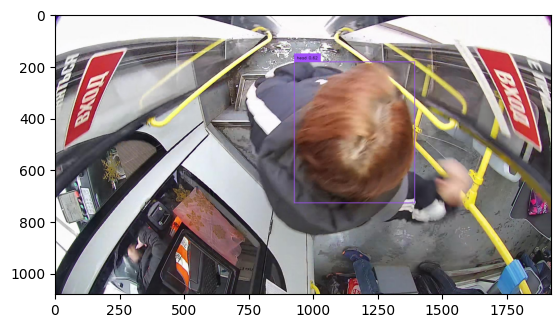

In [22]:
img = plt.imread(f'{OUTPUT_DIR}/apc_test/frame_000093.jpg')
plt.imshow(img)
plt.show()

На основе полученных результатов можно убрать самые неэффективные запросы

In [33]:
head_prompts = ["head", "human head", "head . cap . hat", "head from above", "top of head"]

#### Подсчёт по кадрам нескольких видеофрагментов

In [ ]:
dirs = [d for d in os.listdir(FRAMES_DIR) 
        if not d.startswith('.') and os.path.isdir(os.path.join(FRAMES_DIR, d))]
dino_results = compute_metrics(dino_process_images_with_metrics, dirs, head_prompts, save_imgs=False)

Результаты: 


#### Обработка видео других кейсов

In [50]:
dino_process_video('cig_2.mp4', cig_prompts[0])

In [ ]:
dino_process_video('dsm_phone.mp4', phone_prompts[0])

# YOLO-World

[Ссылка на репозиторий](https://github.com/AILab-CVC/YOLO-World)

### Загрузка конфигурации

In [ ]:
import numpy as np
from mmengine.config import Config
from mmengine.dataset import Compose
from mmengine.runner import Runner
from mmengine.runner.amp import autocast
from mmyolo.registry import RUNNERS
from torchvision.ops import nms
from mmengine.registry import Registry


if __name__ == "__main__":
    # load config
    cfg = Config.fromfile(
        "/home/jovyan/models/YOLO-World/configs/pretrain/yolo_world_v2_l_vlpan_bn_2e-3_100e_4x8gpus_obj365v1_goldg_train_1280ft_lvis_minival.py"
    )
    cfg.work_dir = "."
    cfg.load_from = "/home/jovyan/models/YOLO-World/pretrained_weights/yolo_world_v2_l_obj365v1_goldg_pretrain_1280ft-9babe3f6.pth"
    runner = Runner.from_cfg(cfg)
    runner.call_hook("before_run")
    runner.load_or_resume()
    pipeline = cfg.test_dataloader.dataset.pipeline
    runner.pipeline = Compose(pipeline)

    # run model evaluation
    runner.model.eval()

In [18]:
import PIL.Image
import cv2

bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_position=sv.Position.CENTER)
mask_annotator = sv.MaskAnnotator()

def yolo_process_images_with_metrics(
        runner,
        image_dir,
        class_names,
        save_imgs,
        iou_threshold,
        max_num_boxes=100,
        score_thr=0.05,
        nms_thr=0.5,
        output_image="output.png"
):
    os.makedirs(f"{OUTPUT_DIR}/{image_dir}", exist_ok=True)
    total_tp = 0
    total_fp = 0
    total_fn = 0
    for i, frame in enumerate(sorted(os.listdir(f"{FRAMES_DIR}/{image_dir}")), start=1):
        if not frame.endswith('.jpg'):
            continue
        input_image = f"{FRAMES_DIR}/{image_dir}/{frame}"
        output_image = f"{OUTPUT_DIR}/{image_dir}/{i:04d}.jpg"
        texts = [[t.strip()] for t in class_names.split(",")] + [[" "]]
        data_info = runner.pipeline(dict(img_id=0, img_path=input_image,
                                         texts=texts))
        data_batch = dict(
            inputs=data_info["inputs"].unsqueeze(0),
            data_samples=[data_info["data_samples"]],
        )

        with autocast(enabled=False), torch.no_grad():
            output = runner.model.test_step(data_batch)[0]
            runner.model.class_names = texts
            pred_instances = output.pred_instances

        # nms
        keep_idxs = nms(pred_instances.bboxes, pred_instances.scores, iou_threshold=nms_thr)
        pred_instances = pred_instances[keep_idxs]
        pred_instances = pred_instances[pred_instances.scores.float() > score_thr]

        if len(pred_instances.scores) > max_num_boxes:
            indices = pred_instances.scores.float().topk(max_num_boxes)[1]
            pred_instances = pred_instances[indices]
        output.pred_instances = pred_instances

        # predictions
        pred_instances = pred_instances.cpu().numpy()

        if 'masks' in pred_instances:
            masks = pred_instances['masks']
        else:
            masks = None

        detections = sv.Detections(
            xyxy=pred_instances['bboxes'],
            class_id=pred_instances['labels'],
            confidence=pred_instances['scores']
        )

        # label ids with confidence scores
        labels = [
            f"{class_id} {confidence:0.2f}"
            for class_id, confidence
            in zip(detections.class_id, detections.confidence)
        ]
        pred_boxes = pred_instances['bboxes']
        pred_boxes = [xyxy_to_xywh(box) for box in pred_boxes]
        tp, fp, fn = errors_on_frame(pred_boxes, load_ann(image_dir).get(i, []), iou_threshold)
        total_tp += tp
        total_fp += fp
        total_fn += fn
        
        # draw bounding box with label
        if save_imgs:
            image = PIL.Image.open(input_image)
            svimage = np.array(image)
            svimage = bounding_box_annotator.annotate(svimage, detections)
            svimage = label_annotator.annotate(svimage, detections, labels)
            if masks is not None:
                svimage = mask_annotator.annotate(image, detections)

            # save output image
            cv2.imwrite(output_image, svimage[:, :, ::-1])
    return total_tp, total_fp, total_fn

SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


In [11]:
prompt_group = ("head", "top of head", "head, cap, hat", "head, top of head")

In [25]:
result = compute_metrics(yolo_process_images_with_metrics, ['job_2391'], prompt_group, False, 0.5, runner)

Результаты: 
Prompt: head | Precision: 0.445 | Recall: 0.521 | F1: 0.480 | Errors count: 290
Prompt: top of head | Precision: 0.339 | Recall: 0.467 | F1: 0.393 | Errors count: 371
Prompt: head, cap, hat | Precision: 0.423 | Recall: 0.564 | F1: 0.483 | Errors count: 310
Prompt: head, top of head | Precision: 0.321 | Recall: 0.556 | F1: 0.407 | Errors count: 417


In [13]:
dirs = [d for d in os.listdir(FRAMES_DIR) 
        if not d.startswith('.') and os.path.isdir(os.path.join(FRAMES_DIR, d))]
yolo_results = compute_metrics(runner, dirs, prompt_group, save_imgs=False, iou_threshold=0.5)

Результаты: 
Prompt: head | Precision: 0.551 | Recall: 0.457 | F1: 0.499 | Errors count: 948
Prompt: top of head | Precision: 0.451 | Recall: 0.544 | F1: 0.493 | Errors count: 1158
Prompt: head, cap, hat | Precision: 0.521 | Recall: 0.607 | F1: 0.560 | Errors count: 985
Prompt: head, top of head | Precision: 0.417 | Recall: 0.609 | F1: 0.495 | Errors count: 1286


Пример разметки:

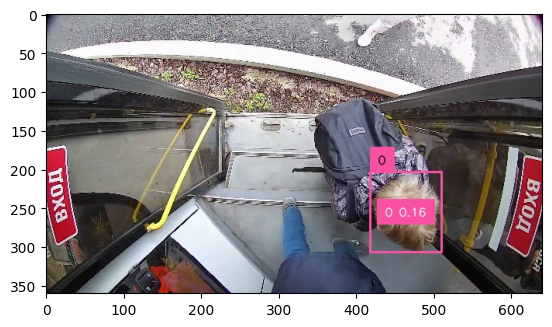

In [20]:
img = plt.imread(f'{OUTPUT_DIR}/job_2344/0170.jpg')
plt.imshow(img)
plt.show()

# Работа с Grounded SAM-2

[Ссылка на репозиторий](https://github.com/IDEA-Research/Grounded-SAM-2)

In [26]:
!/home/jovyan/envs/test/bin/python3 /home/jovyan/Grounded-SAM-2/grounded_sam2_hf_model_demo.py  \
--text-prompt "head." \
--img-path "/home/jovyan/test_frames/job_2562/00000168.jpg"

Результат работы Grounding Dino

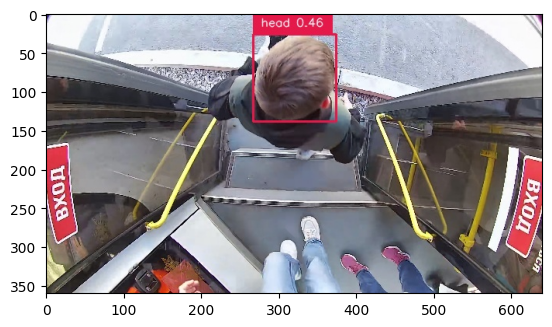

In [12]:
img = plt.imread('/home/jovyan/outputs/test_sam2.1/groundingdino_annotated_image.jpg')
plt.imshow(img)
plt.show()

Результат работы Grounded Sam 2

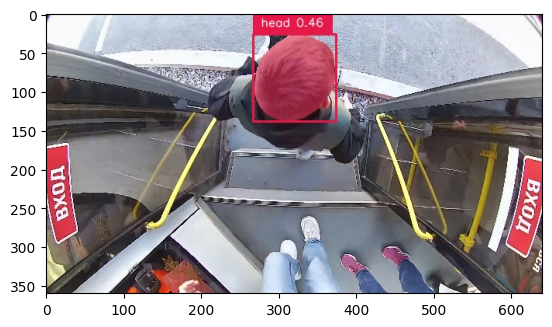

In [11]:
img = plt.imread('/home/jovyan/outputs/test_sam2.1/grounded_sam2_annotated_image_with_mask.jpg')
plt.imshow(img)
plt.show()

# Вывод

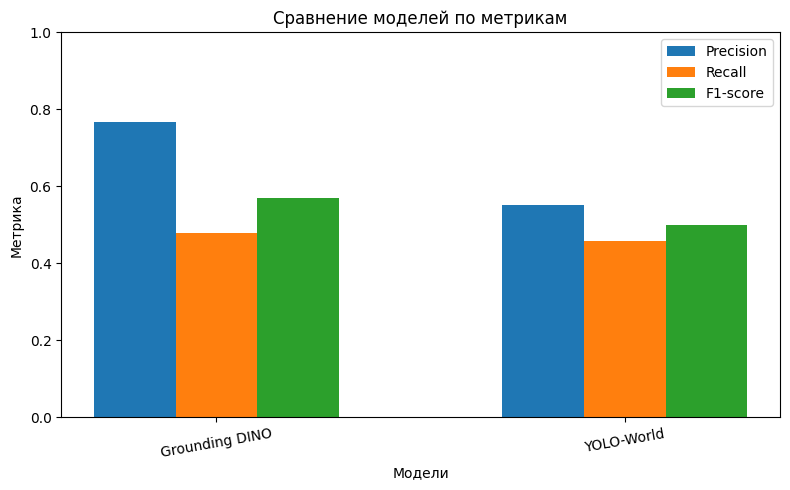

In [3]:
import matplotlib.pyplot as plt
import numpy as np


models = ['Grounding DINO', 'YOLO-World']
precision = [0.766, 0.551]
recall = [0.48, 0.457]
f1 = [0.57, 0.499]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1-score')

ax.set_ylabel('Метрика')
ax.set_xlabel('Модели')
ax.set_title('Сравнение моделей по метрикам')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=10)
ax.legend()
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()